In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import time
import math
import sys
import gensim
import os
import warnings
import itertools
from collections import Counter
from inspect import signature
from scipy.stats import ks_2samp
from sklearn.metrics import precision_recall_curve, f1_score, auc

sys.path.append("../../oats")
from oats.utils.utils import save_to_pickle, load_from_pickle, merge_list_dicts
from oats.datasets.dataset import Dataset
from oats.datasets.groupings import Groupings
from oats.datasets.string import get_stringdb_information
from oats.annotation.ontology import Ontology
from oats.annotation.annotation import write_annotations_to_tsv_file, read_annotations_from_tsv_file
from oats.graphs.pairwise import pairwise_edgelist_doc2vec, pairwise_edgelist_counting, pairwise_edgelist_annotations
from oats.graphs.pairwise import merge_edgelists, subset_edgelist_with_ids
from oats.graphs.pairwise import remove_self_loops

mpl.rcParams["figure.dpi"] = 400
warnings.simplefilter('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [46]:
# Scheme for how to create an overall table of values for each method, level, and metric.
from collections import defaultdict
report = defaultdict(dict)
report["m1"].update({("protein-protein","n_1"):2352, ("protein-protein","n_0"):356})
report["m2"].update({("protein-protein","n_1"):2342, ("protein-protein","n_0"):3564})
report["m2"].update({("functional class","n_1"):2352, ("functional class","n_0"):356})
report["m1"].update({("functional class","n_1"):2352, ("functional class","n_0"):356})
rdf = pd.DataFrame(report).transpose()
print(rdf)

report = defaultdict(dict)

   protein-protein       functional class     
               n_1   n_0              n_1  n_0
m1            2352   356             2352  356
m2            2342  3564             2352  356


## Protein-Protein Interactions

## 1. Does the graph recapitulate known protein-protein interactions?
The different sections in this notebook correspond to different ways of determining if the graphs based on similarity between text descriptions, encodings of text descriptions, or annotations derived from text descriptions at all correspond to known protein-protein interactions in this dataset. The knowledge source about the protein-protein interactions for genes in this dataset is the STRING database (https://string-db.org/). The available entries in the whole dataset are subset to include only the genes that correspond to proteins that are atleast mentioned in the STRING database. This ways if a protein-protein interaction is not specified between two of the remaining genes, it is not because no interactions at all are documented either of those genes. The following cells focus on setting up a dataframe which specifies edge lists specific to each similarity method, and also a protein-protein interaction score for the genes which correspond to those two given nodes in the graphs.

In [41]:
# Reading in the entire dataset, subsetting for Arabidopsis and all annotation types.
dataset = load_from_pickle("../data/pickles/full_dataset.pickle")
dataset.describe()
dataset.filter_by_species("ath")
dataset.collapse_by_all_gene_names()
dataset.filter_has_description()
dataset.filter_has_annotation()
dataset.describe()

Number of rows in the dataframe: 47151
Number of unique IDs:            47151
Number of unique descriptions:   16504
Number of unique gene name sets: 47151
Number of species represented:   6
Number of rows in the dataframe: 5972
Number of unique IDs:            5972
Number of unique descriptions:   3635
Number of unique gene name sets: 5972
Number of species represented:   1


In [42]:
# Reduce size of the dataset by removing genes not mentioned in the STRING.
string_database_file = "../data/group_related_files/string/3702.protein.links.detailed.v11.0.txt"
string_df, string_id_list = get_stringdb_information(string_database_file, dataset.get_name_to_id_dictionary())
dataset.filter_with_ids(string_id_list)
dataset.filter_random_k(100)
dataset.describe()

Number of rows in the dataframe: 100
Number of unique IDs:            100
Number of unique descriptions:   94
Number of unique gene name sets: 100
Number of species represented:   1


In [43]:
# Objects and dictionaries needed to build the list of edges for the full graph.
doc2vec_model_filename = "../gensim/enwiki_dbow/doc2vec.bin"
doc2vec_model = gensim.models.Doc2Vec.load(doc2vec_model_filename)
ontology_filename = "../ontologies/mo.obo"
ontology = Ontology(ontology_filename)
descriptions = dataset.get_description_dictionary()
annotations = dataset.get_annotations_dictionary()
# Generating the pairwise edgelist and saving it as a dataframe.
name_to_df_mapping = {}
name_to_df_mapping["doc2vec"] = pairwise_edgelist_doc2vec(doc2vec_model, descriptions, metric="cosine")
name_to_df_mapping["bagofwords"] = pairwise_edgelist_counting(descriptions, binary=False, metric="cosine") 
name_to_df_mapping["setofwords"] = pairwise_edgelist_counting(descriptions, binary=True, metric="cosine")
name_to_df_mapping["ontology"] = pairwise_edgelist_annotations(annotations, ontology, binary=True, metric="cosine")
df = merge_edgelists(name_to_df_mapping, default_value=0.000)
df = remove_self_loops(df)
print(df.head(8))
print(df.shape[0])

   from     to   doc2vec  bagofwords  setofwords  ontology
1  1537  26576  0.608979    0.984615    0.902177  0.135823
2  1537  16679  0.529413    1.000000    1.000000  0.425792
3  1537   1070  0.493123    0.915366    0.797047  0.167447
4  1537    618  0.543019    1.000000    1.000000  0.546180
5  1537  21936  0.508964    0.926200    0.902177  0.104012
6  1537    519  0.518502    0.972697    0.936372  0.126421
7  1537   1237  0.629592    0.881972    0.820891  0.187875
8  1537   6585  0.445380    0.865385    0.749687  0.138253
4950


In [44]:
# Merging information from the protein-protein interaction database with this dataset.
df = df.merge(right=string_df, how="left", on=["from","to"])
df.fillna(value=0,inplace=True)
print(df.head(5))
print(df.shape)

   from     to   doc2vec  bagofwords  setofwords  ontology  combined_score
0  1537  26576  0.608979    0.984615    0.902177  0.135823             0.0
1  1537  16679  0.529413    1.000000    1.000000  0.425792             0.0
2  1537   1070  0.493123    0.915366    0.797047  0.167447             0.0
3  1537    618  0.543019    1.000000    1.000000  0.546180             0.0
4  1537  21936  0.508964    0.926200    0.902177  0.104012             0.0
(4958, 7)


### 1.1 Do the edges joining interacting proteins come from a different distribution?
This section uses a statistical test (Kolmogorov-Smirnov) to see if the distributions of edge weights which correspond to edges representing a known protein interaction come from a different distribution than the edge weights for edges that do not. This test was chosen because the sizes of the two samples can be different and there is no assumption of normality for the underlying distributions. 

In [45]:
METHODS = ["doc2vec", "bagofwords", "setofwords", "ontology"]

In [47]:
# Use KS test to see if protein-protein interaction edges come from a unique distribution.
ppi_pos_dict = {name:(df[df["combined_score"] > 0.00][name].values) for name in METHODS}
ppi_neg_dict = {name:(df[df["combined_score"] == 0.00][name].values) for name in METHODS}
results = {}
for name in METHODS:
    stat,p = ks_2samp(ppi_pos_dict[name],ppi_neg_dict[name])
    pos_mean = np.average(ppi_pos_dict[name])
    neg_mean = np.average(ppi_neg_dict[name])
    pos_n = len(ppi_pos_dict[name])
    neg_n = len(ppi_neg_dict[name])
    results[name] = {"int_mean":pos_mean,"not_mean":neg_mean,"n_int":pos_n,"n_not":neg_n,"D":stat,"p_value":p}  
    
    
    # NEW PART
    domain = "protein-protein"
    report[name].update({(domain,"D"):stat})
    
    

print(pd.DataFrame(results).transpose())

            int_mean  not_mean  n_int   n_not         D       p_value
doc2vec     0.454761  0.451333  243.0  4715.0  0.065151  2.681042e-01
bagofwords  0.866536  0.878207  243.0  4715.0  0.070416  1.922750e-01
setofwords  0.876747  0.895138  243.0  4715.0  0.119123  2.574218e-03
ontology    0.241925  0.339653  243.0  4715.0  0.221540  1.932932e-10


### 1.2 What do those distributions of edge weights in the graph look like?
Visualization of the densities of the distributions that are tested in the previous cell. This is a check to see if the differences between the distribution of weights based on text-similarity corresponding to known protein-protein interactions are distinct enough those that do not to be practically useful in predicting interactions based on text-similarity.

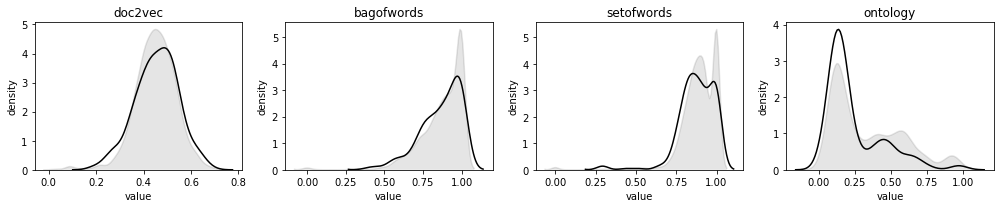

In [48]:
num_plots, plots_per_row, row_width, row_height = (len(METHODS), 4, 14, 3)
fig,axs = plt.subplots(math.ceil(num_plots/plots_per_row), plots_per_row, squeeze=False)
for col,ax in zip(METHODS,axs.flatten()):
    ax.set_title(col)
    ax.set_xlabel("value")
    ax.set_ylabel("density")
    sns.kdeplot(ppi_pos_dict[col], color="black", shade=False, alpha=1.0, ax=ax)
    sns.kdeplot(ppi_neg_dict[col], color="black", shade=True, alpha=0.1, ax=ax) 
    
fig.set_size_inches(row_width, row_height*math.ceil(num_plots/plots_per_row))
fig.tight_layout()
fig.show()

### 1.3 Can we practically use the graph to predict known protein-protein interactions?
This is a different question than above, because the false positive rate is a limiting factor in how practically useful it would be to generate predictions about real protein interactions. In the case of the statistical test above, the sample distribution could be significantly different than the whole distribution of edge values even if there are many high valued edges which look like they could come from the sample distribution. In other words, the sample distribution could be distinct because of a lack of low edge weight values, not there could still be many high edge weight values that are not positive edges in this case, which represent false positives).

               auc baseline n_int n_not
doc2vec     0.0504   0.0490   243  4715
bagofwords  0.0540   0.0490   243  4715
setofwords  0.0605   0.0490   243  4715
ontology    0.0664   0.0490   243  4715


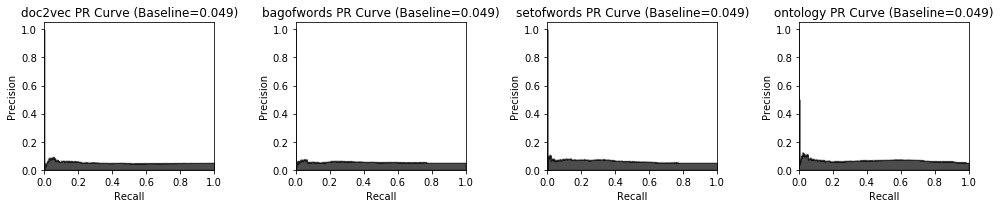

In [56]:
# Generate the targe class values, 1 indicating interaction and 0 indicating no interaction.
y_true_dict = {name:(np.where(df["combined_score"] > 0.000, 1, 0)) for name in METHODS}
y_prob_dict = {name:(1 - df[name].values) for name in METHODS}
results = {}
num_plots, plots_per_row, row_width, row_height = (len(METHODS), 4, 14, 3)
fig,axs = plt.subplots(math.ceil(num_plots/plots_per_row), plots_per_row, squeeze=False)
for method,ax in zip(METHODS, axs.flatten()):
    # Obtaining the values and metrics.
    y_true, y_prob = y_true_dict[method], y_prob_dict[method]
    n_pos, n_neg = Counter(y_true)[1], Counter(y_true)[0]
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    baseline = Counter(y_true)[1]/len(y_true) 
    area = auc(recall, precision)
    auc_to_baseline_auc_ratio = area/baseline
    results[method] = {"auc":"{:.4f}".format(area),
                       "baseline":"{:.4f}".format(baseline),
                       "n_int":"{:.0f}".format(n_pos),
                       "n_not":"{:.0f}".format(n_neg)}
    # Producing the precision recall curve.
    step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
    ax.step(recall, precision, color='black', alpha=0.2, where='post')
    ax.fill_between(recall, precision, alpha=0.7, color='black', **step_kwargs)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title("{0} PR Curve (Baseline={1:0.3f})".format(method, baseline))
    
    
    # NEW PART
    domain = "protein-protein"
    report[method].update({(domain,"AUC"):area, (domain,"AUC/BL"):auc_to_baseline_auc_ratio})
    
    
    
    
    
# Report the results and show the precision recall curves.
print(pd.DataFrame(results).transpose())
fig.set_size_inches(row_width, row_height*math.ceil(num_plots/plots_per_row))
fig.tight_layout()
fig.show()

### 1.4 Can the graph be queried with one gene to successfully return other genes that it interacts with?
This question is similar (potentially overlapping) with a question asked above, which is to ask if genes in the network are connected by highly weighted edges to genes that gene interacts with in the protein-protein interaction data. If this is true, than we can query (return the nodes in order of greatest similarity to the query node) the network with one gene and get back genes that are likely to interact with it. The difference in how this is tested is that only the genes with atleast one known interaction partner are used as the queried proteins. This is mainly just a difference in the visualization? What's actually shown is where the interacting proteins are ranking against all the proteins in the dataset (which is just those proteins atleast mentioned in STRING for this species). When binning the ranks, the bin with the greatest count is the top ranks (1-10), but the ranks that fall in this bin are still a tiny fraction of the total number of returned ranks, so the answer to this question is effectively no.

In [12]:
# Get the list of gene IDs involved in interation with atleast one other protein in this dataset.
genes_with_partners = pd.unique(string_df[["from","to"]].dropna().values.ravel('K'))
partner_ranks_dict = {}

# For each method, obtain a list of the rankings in terms of similarity as measured by that method, using each gene
# iteratively as the query gene. The method of accessing the ranks is to first subset the edgelist dataframe to 
# contain only the rows where an edge involving the node of the query gene is specified, then the edge list is 
# sorted by the specific similarity score for that method, so that the indices of edges where the protein-protein
# interaction score is non-zero will correspond directly to ranks.
for name in METHODS:
    partner_ranks = []
    for gene_id in genes_with_partners:
        merged_df = pd.concat([df[df["from"]==gene_id],df[df["to"]==gene_id]],ignore_index=True)
        merged_df = merged_df.sort_values(by=[name]).reset_index(drop=True)
        indices = merged_df.query("combined_score > 0.00").index.tolist()
        partner_ranks.extend(indices)
    partner_ranks = [rank+1 for rank in partner_ranks]
    partner_ranks_dict[name] = partner_ranks
    print("finished with {}".format(name))

finished with doc2vec
finished with bagofwords
finished with setofwords
finished with ontology


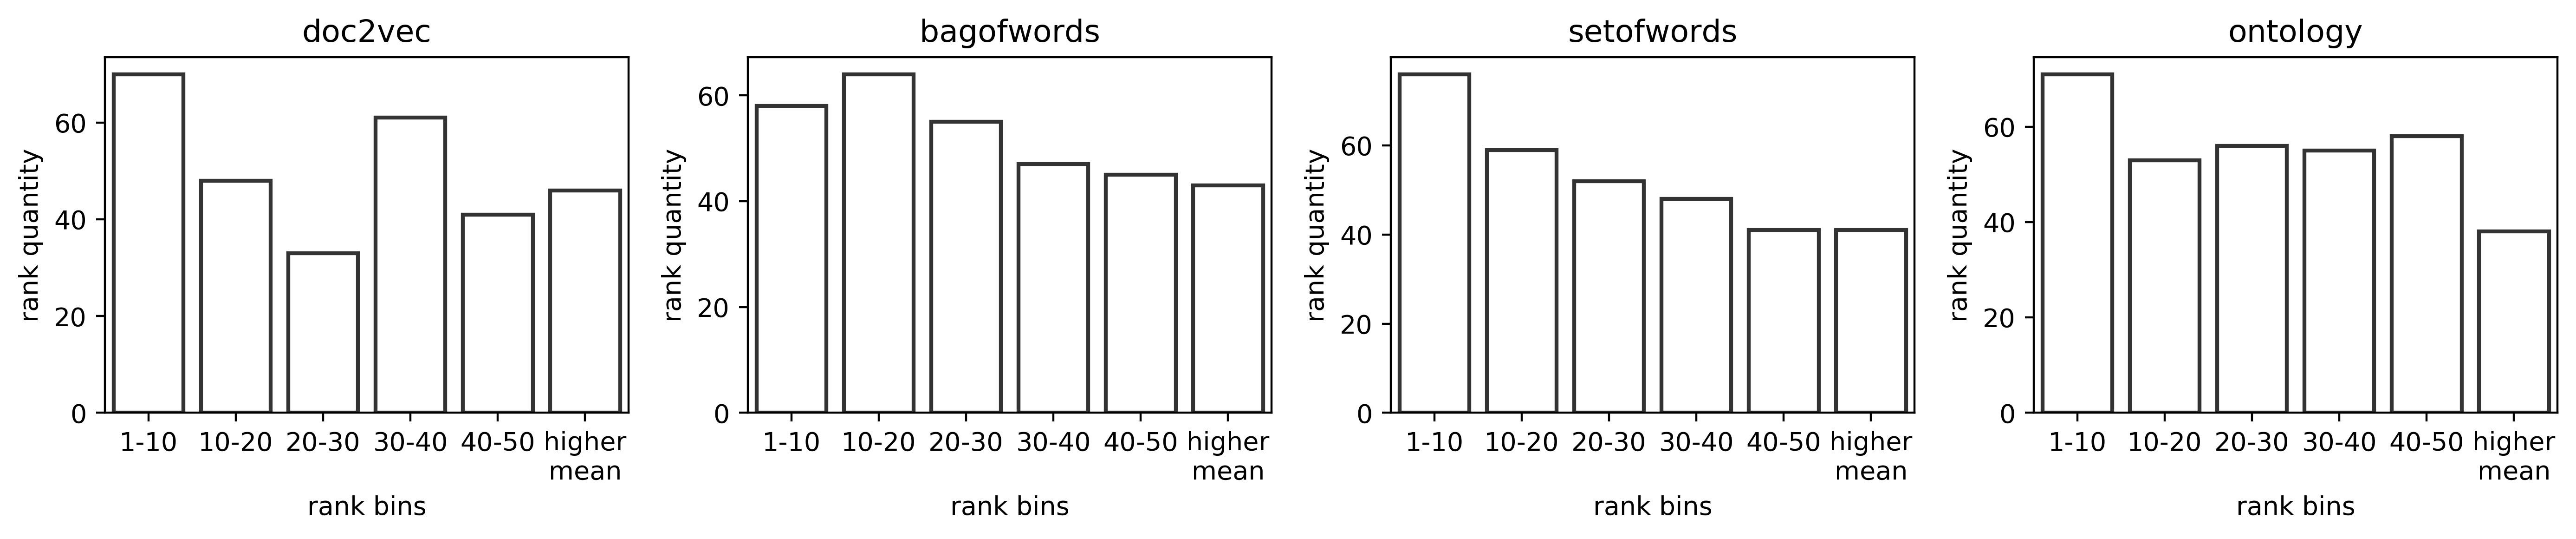

In [13]:
# Set these values to be able to make the large (rightmost) bin an average of all encompassed smaller bins.
# This way the size of that column can be reasonably compared to the columns to its left.
max_rank = len(pd.unique(df[["from","to"]].values.ravel('K')))
bins = [1,10,20,30,40,50,max_rank]
small_bin_size = 10
large_bin_size = (max_rank-50)
ratio = large_bin_size/small_bin_size

# Generate the barplots for each method.
num_plots, plots_per_row, row_width, row_height = (len(METHODS), 4, 14, 3)
fig,axs = plt.subplots(math.ceil(num_plots/plots_per_row), plots_per_row, squeeze=False)
for name,ax in zip(METHODS,axs.flatten()):
    partner_ranks = partner_ranks_dict[name]
    ax.set_title(name)
    ax.set_xlabel("rank bins")
    ax.set_ylabel("rank quantity")
    counts,bin_edges = np.histogram(partner_ranks, bins)
    bin_labels = ["{}-{}".format(bin_edges[i],bin_edges[i+1]) for i in range(len(bin_edges)-1)]
    counts[-1] = counts[-1]/ratio    # Adjust the large bin column to reflect average of encompassed smaller bins.
    bin_labels[-1] = "higher\nmean"  # Change the label of that bin to reflect this change.
    sns.barplot(x=bin_labels,y=counts,linewidth=1.5,facecolor="white",alpha=0.8,errcolor=".2",edgecolor="black",ax=ax)

fig.set_size_inches(row_width, row_height*math.ceil(num_plots/plots_per_row))
fig.tight_layout()
fig.show()

## Functional Groups and Pathways

In [58]:
# Reading in the entire dataset, subsetting for Arabidosis and all annotation types.
dataset = load_from_pickle("../data/pickles/full_dataset.pickle")
dataset.describe()
dataset.filter_by_species("ath")
dataset.collapse_by_all_gene_names()
dataset.filter_has_description()
dataset.filter_has_annotation()
dataset.describe()

Number of rows in the dataframe: 47151
Number of unique IDs:            47151
Number of unique descriptions:   16504
Number of unique gene name sets: 47151
Number of species represented:   6
Number of rows in the dataframe: 5972
Number of unique IDs:            5972
Number of unique descriptions:   3635
Number of unique gene name sets: 5972
Number of species represented:   1


In [59]:
# Subsetting the dataset to include only those genes that map to atleast one group from some classification source.
groups = load_from_pickle(path="../data/pickles/pmn_pathways.pickle")
id_to_group_ids = groups.get_forward_dict(dataset.get_gene_dictionary())
group_mapped_ids = [k for (k,v) in id_to_group_ids.items() if len(v)>1]    
dataset.filter_with_ids(group_mapped_ids)
dataset.filter_random_k(40)
dataset.describe()


# What about subsetting for groups that have atleast two genes mapped to them?

Number of rows in the dataframe: 40
Number of unique IDs:            40
Number of unique descriptions:   36
Number of unique gene name sets: 40
Number of species represented:   1


In [60]:
# Get the mappings again now that the data has been subset.
id_to_group_ids = groups.get_forward_dict(dataset.get_gene_dictionary())
group_id_to_ids = groups.get_reverse_dict(dataset.get_gene_dictionary())
sorted_group_tuples = sorted(group_id_to_ids.items(), key=lambda x: len(x[1]), reverse=True)
print("{:<20}{:<20}{:<20}".format("Num Genes Mapped","Pathway ID", "Pathway Name"))
for group in sorted_group_tuples[:10]:
    print("{:<20}{:<20}{:<20}".format(len(group_id_to_ids[group[0]]), group[0], groups.get_long_name(group[0]))) 

Num Genes Mapped    Pathway ID          Pathway Name        
3                   CITRULBIO-PWY       L-citrulline biosynthesis
3                   PWY66-399           gluconeogenesis III 
3                   GLUCONEO-PWY        gluconeogenesis I   
3                   ALACAT2-PWY         L-alanine degradation II (to D-lactate)
3                   PWY-5971            palmitate biosynthesis II (bacteria and plants)
3                   PWY-5989            stearate biosynthesis II (bacteria and plants)
2                   PWY-1042            glycolysis IV (plant cytosol)
2                   PWY-5723            Rubisco shunt       
2                   PWY-5484            glycolysis II (from fructose 6-phosphate)
2                   GLYCOLYSIS          glycolysis I (from glucose 6-phosphate)


### Optional preprocessing and additional feature selection for the representations
This includes things like whether or not to do capitilization removal, lemmatization, stemming, etc. on the descriptions present in the dataset. This could also included things like scrambling the contexts of each description to establish a baseline performance measure. This could also include things like reducing the vocabulary size through the preprocessing methods given here but also through additional means such as provided a reduced (more specialized) vocabulary dictionary to the vectorizing functions so that only those words which are most likely to have meaning have positions with those vectors. Should also test other vectorization methods such as term-frequency inverse-document-frequency for weighting. Can also change how the feature selection is done for those vectors by altering whether the *n*-grams are based on word or characters, and what the range of *n* is.

In [61]:
# Make a dictionary of descriptions with same quantity of words but randomly selected from the vocabulary.
from nltk.tokenize import word_tokenize
descriptions = dataset.get_description_dictionary()
annotations = dataset.get_annotations_dictionary()
go_annotations = {k:[term for term in v if term[0:2]=="GO"] for k,v in annotations.items()}
po_annotations = {k:[term for term in v if term[0:2]=="PO"] for k,v in annotations.items()}
#tokens = [w for w in itertools.chain.from_iterable(word_tokenize(desc) for desc in descriptions.values())]
#scrambled_descriptions = {k:" ".join(np.random.choice(tokens,len(word_tokenize(v)))) for k,v in descriptions.items()}

In [6]:
combined = {i:descriptions[i]+" "+" ".join(annotations[i]) for i in descriptions.keys()}

### Generating the edge list that specifies the graph constructed from text similarity

In [62]:
# Objects and dictionaries needed to build the list of edges for the full graph.
doc2vec_model_filename = "../gensim/enwiki_dbow/doc2vec.bin"
doc2vec_model = gensim.models.Doc2Vec.load(doc2vec_model_filename)
ontology_filename = "../ontologies/mo.obo"
ontology = Ontology(ontology_filename)
descriptions = dataset.get_description_dictionary()
annotations = dataset.get_annotations_dictionary()
vocabulary = ontology.get_all_tokens_as_ordered_vocabulary()

# Generating the pairwise edgelists for each method.
name_to_df_mapping = {}
name_to_df_mapping["doc2vec"] = pairwise_edgelist_doc2vec(doc2vec_model, descriptions, "cosine")
name_to_df_mapping["bagofwords"] = pairwise_edgelist_counting(descriptions, "cosine", binary=False) 
name_to_df_mapping["setofwords"] = pairwise_edgelist_counting(descriptions, "jaccard", binary=True)
name_to_df_mapping["ontology"] = pairwise_edgelist_annotations(annotations, ontology, "jaccard", binary=True)

In [8]:
# Generating the pairwise edgelists for some additional methods.
name_to_df_mapping["bow_wngram"] = pairwise_edgelist_counting(descriptions, metric="cosine", binary=False, analyzer="word", ngram_range=(1,2))
name_to_df_mapping["bow_cngram"] = pairwise_edgelist_counting(descriptions, metric="cosine", binary=False, analyzer="char", ngram_range=(3,6))
name_to_df_mapping["bow_vocab"] = pairwise_edgelist_counting(descriptions, metric="cosine", binary=False, vocabulary=vocabulary)
name_to_df_mapping["sow_vocab"] = pairwise_edgelist_counting(descriptions, metric="cosine", binary=True, vocabulary=vocabulary)

In [63]:
# Combining results from all the methods used above into a single dataframe.
df = merge_edgelists(name_to_df_mapping, default_value=0.000)
df = remove_self_loops(df)
print(df.head(8))
print(df.shape[0])

   from     to   doc2vec  bagofwords  setofwords  ontology
1   740   3205  0.379552         1.0         1.0  0.890000
2   740    302  0.505100         1.0         1.0  0.816514
3   740   8243  0.420489         1.0         1.0  0.735849
4   740   2161  0.615941         1.0         1.0  0.892562
5   740   1724  0.404323         1.0         1.0  0.804878
6   740   2648  0.574715         1.0         1.0  0.657143
7   740   3259  0.457415         1.0         1.0  0.881081
8   740  16615  0.528389         1.0         1.0  1.000000
780


### Comparing baseline to within-group edge weight distributions

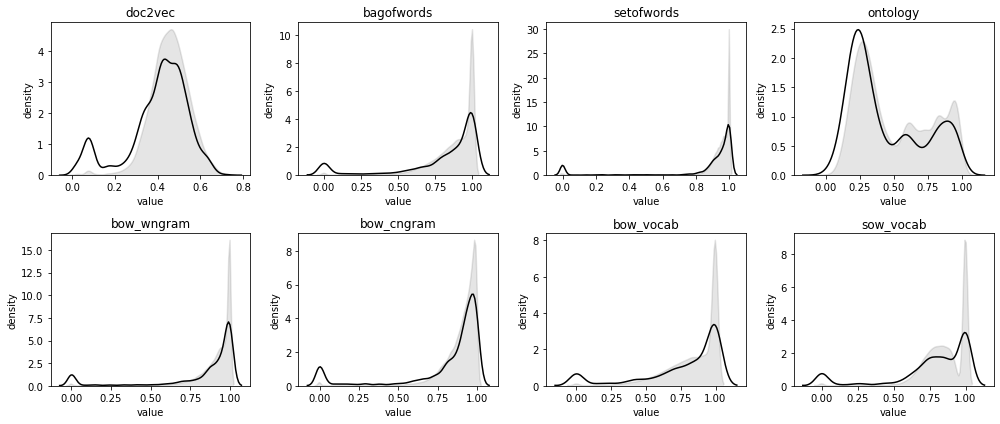

In [11]:
# Obtain the whole-data and within-group edge weight distributions by method.
METHODS = name_to_df_mapping.keys()
group_id_to_ids = groups.get_reverse_dict(dataset.get_gene_dictionary())
group_ids = list(group_id_to_ids.keys())
graph = IndexedGraph(df)
within_weights_dict = defaultdict(list)
all_weights_dict = {}
for method in METHODS:
    all_weights_dict[method] = df[method].values
    for group in group_ids:
        within_ids = group_id_to_ids[group]
        within_pairs = [(i,j) for i,j in itertools.permutations(within_ids,2)]
        within_weights_dict[method].extend(graph.get_values(within_pairs, kind=method))
        
# Plotting the kernel density estimates of the whole-data and within-group distributions.
num_plots, plots_per_row, row_width, row_height = (len(METHODS), 4, 14, 3)
fig,axs = plt.subplots(math.ceil(num_plots/plots_per_row), plots_per_row, squeeze=False)
for method,ax in zip(METHODS,axs.flatten()):
    ax.set_title(method)
    ax.set_xlabel("value")
    ax.set_ylabel("density")
    sns.kdeplot(within_weights_dict[method], color="black", shade=False, alpha=1.0, ax=ax)
    sns.kdeplot(all_weights_dict[method], color="black", shade=True, alpha=0.1, ax=ax) 
fig.set_size_inches(row_width, row_height*math.ceil(num_plots/plots_per_row))
fig.tight_layout()
fig.show()

### Which biochemical pathways are the most 'phenotypically visible' in this dataset?

In [13]:
# Same thing but keeping track of means for each specific pathway or grouping with nested dict.

# Obtain the whole-data and within-group edge weight distributions by method.
METHODS = name_to_df_mapping.keys()
group_id_to_ids = groups.get_reverse_dict(dataset.get_gene_dictionary())
group_ids = list(group_id_to_ids.keys())
graph = IndexedGraph(df)
within_weights_dict = defaultdict(lambda: defaultdict(list))
all_weights_dict = {}
for method in METHODS:
    all_weights_dict[method] = df[method].values
    for group in group_ids:
        within_ids = group_id_to_ids[group]
        within_pairs = [(i,j) for i,j in itertools.permutations(within_ids,2)]
        within_weights_dict[method][group] = np.mean((graph.get_values(within_pairs, kind=method)))

In [14]:
# Find the average rank of each pathway or group in terms of how low the mean within-group distance values were.
ranks = pd.DataFrame(within_weights_dict).rank()
ranks["average"] = ranks.mean(axis=1)
ranks.sort_values(by="average", inplace=True)


ranks.reset_index(inplace=True)
ranks["group_id"] = ranks["index"]
ranks["full_name"] = ranks["group_id"].apply(lambda x: groups.get_long_name(x))
ranks = ranks[["average","full_name"]]
print(ranks.head(10))



#means_df = pd.DataFrame(within_weights_dict)
#means_df.reset_index(inplace=True)
#means_df["name"] = means_df["index"].apply(lambda x: groups.get_long_name(x))

# need to add the values of n to this dataframe for each?




#means_df.sort_values(by=["doc2vec"], inplace=True)
#means_df["rank"] = means_df["doc2vec"].rank()
#print(means_df.head(20))









   average                                          full_name
0   2.0625                          neurosporene biosynthesis
1   5.5000                     caffeoylglucarate biosynthesis
2   6.6250                                lutein biosynthesis
3   6.6250                            zeaxanthin biosynthesis
4   9.3750  UDP-&alpha;-D-galacturonate biosynthesis I (fr...
5  11.7500                                 UMP biosynthesis I
6  11.7500        L-arginine biosynthesis I (via L-ornithine)
7  19.0000                              olivetol biosynthesis
8  19.0000                           resveratrol biosynthesis
9  26.0000                           L-histidine biosynthesis


### Predicting whether two genes share or do not share a functional classification or pathway

In [15]:
# Generate the targe class values, 1 indicating common function and 0 indicating no common function.
df.loc[:,"class"] = [int(len(set(id_to_group_ids[id1]).intersection(set(id_to_group_ids[id2])))>0) 
    for (id1,id2) in zip(df["from"].values,df["to"].values)]
print(df.head(8))

   from     to   doc2vec  bagofwords  setofwords  ontology  bow_wngram  bow_cngram  bow_vocab  sow_vocab  class
1   740   3205  0.379535         1.0         1.0  0.890000         1.0    0.960965        1.0        1.0      0
2   740    302  0.504822         1.0         1.0  0.816514         1.0    0.964336        1.0        1.0      0
3   740   8243  0.420297         1.0         1.0  0.735849         1.0    1.000000        1.0        1.0      0
4   740   2161  0.616142         1.0         1.0  0.892562         1.0    0.978064        1.0        1.0      0
5   740   1724  0.404003         1.0         1.0  0.804878         1.0    1.000000        1.0        1.0      1
6   740   2648  0.574573         1.0         1.0  0.657143         1.0    0.996363        1.0        1.0      0
7   740   3259  0.456270         1.0         1.0  0.881081         1.0    0.996095        1.0        1.0      0
8   740  16615  0.528227         1.0         1.0  1.000000         1.0    0.983509        1.0        1.0

               auc baseline n_shared  n_not
doc2vec     0.0558   0.0245     1955  77845
bagofwords  0.0592   0.0245     1955  77845
setofwords  0.0646   0.0245     1955  77845
ontology    0.0339   0.0245     1955  77845
bow_wngram  0.0541   0.0245     1955  77845
bow_cngram  0.0603   0.0245     1955  77845
bow_vocab   0.0524   0.0245     1955  77845
sow_vocab   0.0549   0.0245     1955  77845


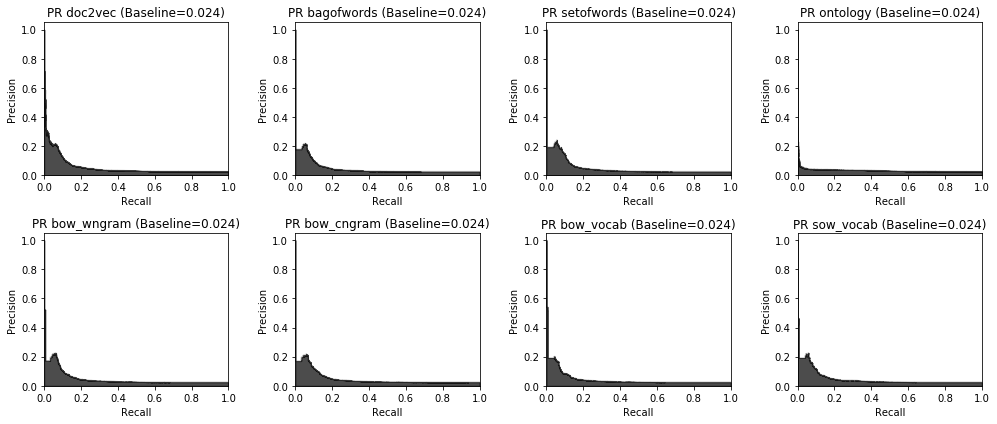

In [16]:
y_true_dict = {name:df["class"] for name in METHODS}
y_prob_dict = {name:(1 - df[name].values) for name in METHODS}
results = {}

num_plots, plots_per_row, row_width, row_height = (len(METHODS), 4, 14, 3)
fig,axs = plt.subplots(math.ceil(num_plots/plots_per_row), plots_per_row, squeeze=False)
for method,ax in zip(METHODS, axs.flatten()):
    # Obtaining the values and metrics.
    y_true, y_prob = y_true_dict[method], y_prob_dict[method]
    n_pos, n_neg = Counter(y_true)[1], Counter(y_true)[0]
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    baseline = Counter(y_true)[1]/len(y_true) 
    area = auc(recall, precision)
    auc_to_baseline_auc_ratio = area/baseline
    results[method] = {"auc":"{:.4f}".format(area), 
                       "baseline":"{:.4f}".format(baseline), 
                       "n_shared":"{:.0f}".format(n_pos), 
                       "n_not":"{:.0f}".format(n_neg)}
    # Producing the precision recall curve.
    step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
    ax.step(recall, precision, color='black', alpha=0.2, where='post')
    ax.fill_between(recall, precision, alpha=0.7, color='black', **step_kwargs)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title("PR {0} (Baseline={1:0.3f})".format(method, baseline))
print(pd.DataFrame(results).transpose())
fig.set_size_inches(row_width, row_height*math.ceil(num_plots/plots_per_row))
fig.tight_layout()
fig.show()